In [1]:
# Import the relevant modules
import os
import sys
import glob

# Import third party modules
import numpy as np
import xarray as xr
import regionmask
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import dictionaries_em as dicts

In [ ]:
# Testing the NUTS shapefiles
# Load in the shapefile fo the eez data
NUTS_shapefile = gpd.read_file("shapefiles/NUTS/NUTS_RG_10M_2021_4326.shp")

In [ ]:
NUTS_shapefile.head()

In [ ]:
# Restrict to level code 0
NUTS_shapefile = NUTS_shapefile[NUTS_shapefile.LEVL_CODE == 0]

In [ ]:
NUTS_shapefile.head()

In [ ]:
# Restrict to only the countries with codes in the countries_nuts_id dictionarry
print(dicts.countries_nuts_id)

In [ ]:
# Extract the second element of the tuple
countries_codes = list(dicts.countries_nuts_id.values())

In [ ]:
# Limit the gpd to the countries in the dictionary
NUTS_shapefile = NUTS_shapefile[NUTS_shapefile.NUTS_ID.isin(countries_codes)]

In [ ]:
NUTS_shapefile.head()

In [ ]:
# Keep only the NUTS_ID, NUTS_NAME, and geometry columns
NUTS_shapefile = NUTS_shapefile[["NUTS_ID", "NUTS_NAME", "geometry"]]

In [ ]:
NUTS_shapefile.head()

### Loading model NAO data ###

Loading the lagged and var adjusted NAO data from the .csv file

In [ ]:
# Define the file dire
nao_df_dir = "/gws/nopw/j04/canari/users/benhutch/nao_stats_df/"
nao_df_fname = "psl_ONDJFM_global_1961_2014_2-9_4_nao_default.csv"

# Set up the model config
model_config = {
    "variable": "psl",
    "season": "ONDJFM",
    "region": "global",
    "start_year": 1961,
    "end_year": 2014,
    "forecast_range": "2-9",
    "lag": 4,
    "nao": "nao_default",
    "gridbox": "North Europe Grid",
    "method": "nao_matched",
}

# # Load this in using pandas
# nao_df = pd.read_csv(nao_df_dir + nao_df_fname)

In [ ]:
# # view the head of the df
# nao_df.head()

Load in the other NAO data

In [ ]:
# # Load the data into chunks
# ds_era5 = xr.open_mfdataset(
#     dicts.regrid_file,
#     combine="by_coords",
#     parallel=True,
#     chunks={"time": "auto", "latitude": "auto", "longitude": "auto"},
# )[
#     "msl"
# ]  # for mean sea level pressure

# # Combine the first two expver variables
# obs_msl = ds_era5.sel(expver=1).combine_first(ds_era5.sel(expver=5))

In [ ]:
# # Constrain obs to ONDJFM
# obs_msl = obs_msl.sel(time=obs_msl.time.dt.month.isin([10, 11, 12, 1, 2, 3]))

# # Shift the time index back by 3 months
# obs_msl_shifted = obs_msl.shift(time=-3)

# # Take annual means
# obs_msl_annual = obs_msl_shifted.resample(time="Y").mean()

# # Throw away years 1959, 2021, 2022 and 2023
# obs_msl_annual = obs_msl_annual.sel(time=slice("1960", "2019"))

# # Remove the climatology
# obs_msl_anomaly = obs_msl_annual - obs_msl_annual.mean(dim="time")

In [ ]:
# # Extract the lats and lons of the azores
# lat1, lat2 = dicts.azores_grid_corrected["lat1"], dicts.azores_grid_corrected["lat2"]
# lon1, lon2 = dicts.azores_grid_corrected["lon1"], dicts.azores_grid_corrected["lon2"]

# # Calculate the mean for the azores gridbox
# obs_msl_anomaly_azores = obs_msl_anomaly.sel(
#     lat=slice(lat1, lat2), lon=slice(lon1, lon2)
# ).mean(dim=["lat", "lon"])

# # Same for iceland
# lat1, lat2 = dicts.iceland_grid_corrected["lat1"], dicts.iceland_grid_corrected["lat2"]
# lon1, lon2 = dicts.iceland_grid_corrected["lon1"], dicts.iceland_grid_corrected["lon2"]

# # Calculate the mean for the iceland gridbox
# obs_msl_anomaly_iceland = obs_msl_anomaly.sel(
#     lat=slice(lat1, lat2), lon=slice(lon1, lon2)
# ).mean(dim=["lat", "lon"])

# # Calculate the NAO index (azores - iceland)
# nao_index = obs_msl_anomaly_azores - obs_msl_anomaly_iceland

In [ ]:
# # EXtract the time series
# nao_index_time = nao_index.time.values

# # Extract the values
# nao_index_values = nao_index.values

# # Create a dataframe
# nao_running = pd.DataFrame({"time": nao_index_time, "value": nao_index_values})

# # Take a centred 8-year running mean
# nao_running = nao_running.set_index("time").rolling(8, center=True).mean()

In [ ]:
# nao_index_values

In [ ]:
# # Drop the Nans
# nao_running = nao_running.dropna()

In [ ]:
# nao_running.head()

In [ ]:
# # split the time column into year and month
# # split by - and take the first element
# nao_running.index = nao_running.index.year

In [ ]:
# nao_running.head()

In [ ]:
# # align the two dataframes by the index of time for nao_running
# # and the valid time for nao_df
# nao_df.head()

In [ ]:
# # Set the index of nao_df as the valid_time column
# nao_df = nao_df.set_index("valid_time")

In [ ]:
# nao_df.head()

In [ ]:
# # join the two dataframes
# nao_df = nao_df.join(nao_running)

In [ ]:
# nao_df.head()

In [ ]:
# # Set the column with name 'value' to obs_nao_pd
# nao_df = nao_df.rename(columns={"value": "obs_nao_pd"})

In [ ]:
# nao_df.head()

In [ ]:
# from scipy.stats import pearsonr

# # Plot the obs_nao and obs_nao_pd, both divided by 100
# # with valid_time (index) on the x-axis
# plt.figure(figsize=(12, 8))

# plt.plot(nao_df.index, nao_df["obs_nao"] / 100, label="ERA5", color="black")

# plt.plot(
#     nao_df.index, nao_df["model_nao_mean"] / 100, label="dcppA-hindcast", color="blue"
# )

# corr, p = pearsonr(nao_df["obs_nao"], nao_df["model_nao_mean"])

# # Include a textbox in the top left hand corner with the corr and p values
# plt.text(
#     0.05,
#     0.95,
#     f"Correlation: {round(corr, 2)}\n p-value: {round(p, 2)}",
#     horizontalalignment="left",
#     verticalalignment="top",
#     transform=plt.gca().transAxes,
#     bbox=dict(facecolor="white", alpha=0.5),
# )

# plt.legend()

# plt.show()

Now we want to process the correlation data for the EEZ domains, then plot the strength of these correlations on the map.

In [ ]:
# # Import the functions
# import functions_em as funcs

# # Extract the data from the .nc file
# eez_cfs = funcs.extract_offshore_eez_to_df(
#     filepath=os.path.join(dicts.clearheads_dir, "EEZ_zones_wp_historical.nc")
# )

In [ ]:
# # Look at the head of the dataframe
# eez_cfs.head()

In [3]:
# Import the functions
import functions_em as funcs

ERROR 1: PROJ: proj_create_from_database: Open of /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/envs/jaspy3.10-mf-22.11.1-4-r20230718/share/proj failed


In [15]:
import importlib

importlib.reload(funcs)

<module 'functions_em' from '/home/users/benhutch/energy-met-corr/functions_em.py'>

In [5]:
nao_df_dir = "/gws/nopw/j04/canari/users/benhutch/nao_stats_df/"
nao_df_fname = "psl_ONDJFM_global_1961_2014_2-9_4_nao_default.csv"

# # Set up the model config
# model_config = {
#     "variable": "psl",
#     "season": "ONDJFM",
#     "region": "global",
#     "start_year": 1961,
#     "end_year": 2014,
#     "forecast_range": "2-9",
#     "lag": 4,
#     "nao": "thornton_2019_uk",
# }

# Set up the model config
model_config = {
    "variable": "psl",
    "season": "ONDJFM",
    "region": "global",
    "start_year": 1961,
    "end_year": 2014,
    "forecast_range": "2-9",
    "lag": 4,
    "nao": "nao_default",
    "gridbox": "Scandinavia",
    "method": "nao_matched",
}


# EEZ_zones_wp_historical.nc
# NUTS_0_HDD_historical_pop_weighted.nc
# test the other function for doing this
# days for cooling degree days
df, merged_df, merged_df_full, corr_df = funcs.correlate_nao_uread(
    filename="NUTS_0_HDD_historical_pop_weighted.nc",
    time_unit="d",
    obs_var="msl",
    avg_grid=dicts.scandi_box,
    use_model_data=True,
    model_config=model_config,
)

NUTS_keys for UREAD data:  ['AT' 'AL' 'BY' 'BE' 'BA' 'BG' 'HR' 'CZ' 'DK' 'EE' 'FI' 'FR' 'DE' 'GR'
 'HU' 'IE' 'IT' 'XK' 'LV' 'LT' 'LU' 'MK' 'MD' 'ME' 'NL' 'NO' 'PL' 'PT'
 'RO' 'RS' 'SK' 'SI' 'ES' 'SE' 'CH' 'TR' 'UA' 'UK']
Extracting the stored NAO data from the model data.
Filepath:  /gws/nopw/j04/canari/users/benhutch/nao_stats_df/psl_ONDJFM_global_1961_2014_2-9_4_nao_default.csv
Filepath:  /gws/nopw/j04/canari/users/benhutch/nao_stats_df/psl_ONDJFM_global_1961_2014_2-9_4_nao_default.csv
Head of merged_df:              init_time     obs_nao  model_nao_mean  model_nao_members_min  \
valid_time                                                                 
1969             1964 -354.681580     -267.841253            -439.194590   
1970             1965 -215.043700     -276.476331            -447.829668   
1971             1966 -203.877410     -284.130047            -455.483384   
1972             1967 -147.214690     -191.507105            -362.860442   
1973             1968   -3.7612

In [10]:
merged_df.head()

,init_time,obs_nao,model_nao_mean,model_nao_members_min,model_nao_members_max,NAO anomaly (Pa)
valid_time,,,,,,
1969,1964,-354.681580,-267.841253,-439.194590,-96.487916,-348.475141
1970,1965,-215.043700,-276.476331,-447.829668,-105.122993,-208.837811
1971,1966,-203.877410,-284.130047,-455.483384,-112.776710,-197.671553
1972,1967,-147.214690,-191.507105,-362.860442,-20.153768,-141.009079
1973,1968,-3.761232,-181.768159,-353.121496,-10.414822,2.444138


In [16]:
nao_df, pr_df = funcs.calc_model_nao_gridbox_var_corr(
    nao_df=merged_df,
    gridbox=dicts.scandi_box,
    obs_var="var228",
    obs_var_data_path=dicts.regrid_file_pr,
)

In [18]:
nao_df.head()

,init_time,obs_nao,model_nao_mean,model_nao_members_min,model_nao_members_max,NAO anomaly (Pa)
valid_time,,,,,,
1969,1964,-354.681580,-267.841253,-439.194590,-96.487916,-348.475141
1970,1965,-215.043700,-276.476331,-447.829668,-105.122993,-208.837811
1971,1966,-203.877410,-284.130047,-455.483384,-112.776710,-197.671553
1972,1967,-147.214690,-191.507105,-362.860442,-20.153768,-141.009079
1973,1968,-3.761232,-181.768159,-353.121496,-10.414822,2.444138


In [25]:
pr_df

,var228 anomaly mean
time,
1964,-1.124663e-04
1965,-1.514610e-04
1966,-1.941997e-04
1967,-1.272582e-04
1968,-7.287815e-05
1969,-2.969311e-05
1970,1.969044e-05
1971,-1.888659e-06
1972,-5.642282e-06


In [21]:
# Extract the time axis for pr_df to only include the years
pr_df.index = pr_df.index.year

In [23]:
# Join the two dataframes
merged_df = nao_df.join(pr_df, how="inner")

In [31]:
merged_df.head()

,init_time,obs_nao,model_nao_mean,model_nao_members_min,model_nao_members_max,NAO anomaly (Pa),var228 anomaly mean,calibrated_model_nao_mean,calibrated_model_nao_members_min,calibrated_model_nao_members_max
1969,1964,-3.546816,-2.678413,-4.391946,-0.964879,-3.484751,-0.029693,NaN,NaN,NaN
1970,1965,-2.150437,-2.764763,-4.478297,-1.051230,-2.088378,0.019690,NaN,NaN,NaN
1971,1966,-2.038774,-2.841300,-4.554834,-1.127767,-1.976716,-0.001889,NaN,NaN,NaN
1972,1967,-1.472147,-1.915071,-3.628604,-0.201538,-1.410091,-0.005642,NaN,NaN,NaN
1973,1968,-0.037612,-1.817682,-3.531215,-0.104148,0.024441,0.026471,NaN,NaN,NaN


In [26]:
# Convert the column var228 anomaly mean to mm day
# by multiplying by 1000
merged_df["var228 anomaly mean"] = merged_df["var228 anomaly mean"] * 1000

In [28]:
# convert NAO columns to hpa
merged_df["obs_nao"] = merged_df["obs_nao"] / 100
merged_df["model_nao_mean"] = merged_df["model_nao_mean"] / 100
merged_df["model_nao_members_min"] = merged_df["model_nao_members_min"] / 100
merged_df["model_nao_members_max"] = merged_df["model_nao_members_max"] / 100
merged_df["NAO anomaly (Pa)"] = merged_df["NAO anomaly (Pa)"] / 100

In [30]:
# Create new columns for "calibrated_model_nao_mean", "calibrated_model_nao_members_min"
# and "calibrated_model_nao_members_max"
merged_df["calibrated_model_nao_mean"] = np.nan
merged_df["calibrated_model_nao_members_min"] = np.nan
merged_df["calibrated_model_nao_members_max"] = np.nan

In [37]:
# extract the slope and intercept coefficients
coeffs_file = "coeffs/nao_pr_scandi_slope.csv"

# Load in the coefficients
coeffs_df = pd.read_csv(coeffs_file)

# Extract the calibration coefficients
slope = coeffs_df["slope"].values[0]
intercept = coeffs_df["intercept"].values[0]

# # Calibrate the model data
merged_df["calibrated_model_nao_mean"] = merged_df["model_nao_mean"] * slope + intercept
merged_df["calibrated_model_nao_members_min"] = (
    merged_df["model_nao_members_min"] * slope + intercept
)
merged_df["calibrated_model_nao_members_max"] = (
    merged_df["model_nao_members_max"] * slope + intercept
)

In [38]:
merged_df.head()

,init_time,obs_nao,model_nao_mean,model_nao_members_min,model_nao_members_max,NAO anomaly (Pa),var228 anomaly mean,calibrated_model_nao_mean,calibrated_model_nao_members_min,calibrated_model_nao_members_max
1969,1964,-3.546816,-2.678413,-4.391946,-0.964879,-3.484751,-0.029693,-0.076406,-0.122861,-0.029951
1970,1965,-2.150437,-2.764763,-4.478297,-1.051230,-2.088378,0.019690,-0.078747,-0.125202,-0.032292
1971,1966,-2.038774,-2.841300,-4.554834,-1.127767,-1.976716,-0.001889,-0.080822,-0.127277,-0.034367
1972,1967,-1.472147,-1.915071,-3.628604,-0.201538,-1.410091,-0.005642,-0.055711,-0.102166,-0.009256
1973,1968,-0.037612,-1.817682,-3.531215,-0.104148,0.024441,0.026471,-0.053071,-0.099526,-0.006616


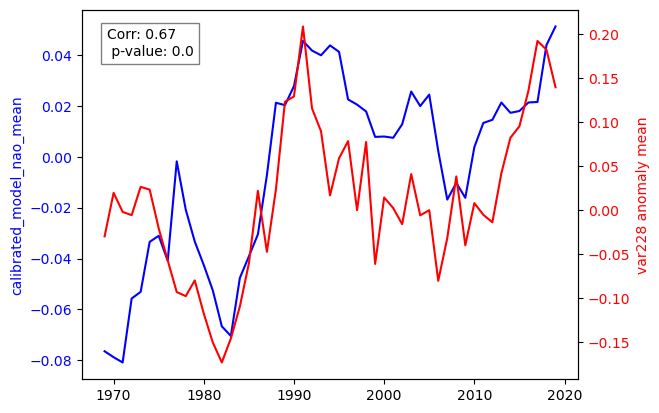

In [41]:
# Plot the calibrated_model_nao_mean against the var228 anomaly mean
# with seperate y-axes
from scipy.stats import pearsonr

# Create a new figure and an axes
fig, ax1 = plt.subplots()

# Plot the calibrated_model_nao_mean on the first y-axis
ax1.plot(merged_df.index, merged_df["calibrated_model_nao_mean"], color="blue")
ax1.set_ylabel("calibrated_model_nao_mean", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the var228 anomaly mean on the second y-axis
ax2.plot(merged_df.index, merged_df["var228 anomaly mean"], color="red")
ax2.set_ylabel("var228 anomaly mean", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# show the correlation coefiients
corr, p = pearsonr(
    merged_df["calibrated_model_nao_mean"], merged_df["var228 anomaly mean"]
)

# Include a textbox in the top left hand corner with the corr and p values
plt.text(
    0.05,
    0.95,
    f"Corr: {round(corr, 2)}\n p-value: {round(p, 2)}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# Show the plot
plt.show()

In [ ]:
# Testing the NUTS shapefiles
# Load in the shapefile fo the eez data
NUTS_shapefile = gpd.read_file("shapefiles/NUTS/NUTS_RG_10M_2021_4326.shp")

# Restrict to level code 0
NUTS_shapefile = NUTS_shapefile[NUTS_shapefile.LEVL_CODE == 0]

# Extract the second element of the tuple
countries_codes = list(dicts.countries_nuts_id.values())

# Limit the gpd to the countries in the dictionary
NUTS_shapefile = NUTS_shapefile[NUTS_shapefile.NUTS_ID.isin(countries_codes)]

# Keep only the NUTS_ID, NUTS_NAME, and geometry columns
NUTS_shapefile = NUTS_shapefile[["NUTS_ID", "NUTS_NAME", "geometry"]]

In [ ]:
NUTS_shapefile.head()

In [ ]:
# Load in the shapefile fo the eez data
EEZ_shapefile = gpd.read_file("shapefiles/EEZ/eez_v12.shp")

In [ ]:
EEZ_shapefile.head()

In [ ]:
# Print all of the column names for the eeZ shapefile
print(EEZ_shapefile.columns)

In [ ]:
# Throw away all of the columns, apart from "GEONAME", 'SOVEREIGN1',
# "ISOSOV1", "geometry"
EEZ_shapefile = EEZ_shapefile[["GEONAME", "SOVEREIGN1", "ISO_SOV1", "geometry"]]

In [ ]:
EEZ_shapefile.head()

In [ ]:
iso_sov1 = EEZ_shapefile["ISO_SOV1"].values

In [ ]:
iso_sov1

In [ ]:
# Extract the values of the region column from corr_df
region_values = corr_df.region.values

In [ ]:
region_values

In [ ]:
# reload the dictionary
importlib.reload(dicts)

In [ ]:
# Convert the region values to equivalent iso_sov1 values
# using the mapping in the dictionary
iso_sov1_values = [dicts.iso_mapping[region] for region in region_values]

In [ ]:
iso_sov1_values

In [ ]:
# Constrain the geo dataframe to only include the iso_sov1 values
EEZ_shapefile = EEZ_shapefile[EEZ_shapefile["ISO_SOV1"].isin(iso_sov1_values)]

In [ ]:
# Find where ISO_SOV1 is equal to "ITA"
EEZ_shapefile.head()

In [ ]:
# Where corr_df.region passed through iso_mapping dict is
# equal to the values in EEZ_shapefile.ISO_SOV1
# Add the corresponding correlation and p-value to the dataframe

In [ ]:
# Filter df to only include the rows where GEONAME includes: "Exclusive Economic Zone"
EEZ_shapefile = EEZ_shapefile[
    EEZ_shapefile["GEONAME"].str.contains("Exclusive Economic Zone")
]

In [ ]:
EEZ_shapefile.head()

In [ ]:
# Now we want to append the correlation and p-value to the dataframe
# Add a new column to corr_df called "ISO_SOV1"
corr_df["ISO_SOV1"] = iso_sov1_values

In [ ]:
corr_df["region"] == "EL"

In [ ]:
# Loop over the columns in EEZ_shapefile and add the correlation and p-value
# where the ISO_SOV1 values are equal
for index, row in EEZ_shapefile.iterrows():
    # Extract the ISO_SOV1 value
    iso_sov1 = row["ISO_SOV1"]
    # Find the index of the row in corr_df that matches the ISO_SOV1
    index_corr = corr_df[corr_df["ISO_SOV1"] == iso_sov1].index
    # Add the correlation and p-value to the dataframe
    EEZ_shapefile.loc[index, "correlation"] = corr_df.loc[
        index_corr, "correlation"
    ].values
    EEZ_shapefile.loc[index, "p-value"] = corr_df.loc[index_corr, "p-value"].values

In [ ]:
# Same thing for the NUTS_shapefile
for index, row in NUTS_shapefile.iterrows():
    # Extract the NUTS_ID value
    nuts_id = row["NUTS_ID"]

    # Find the index of the row in corr_df that matches the NUTS_ID
    index_corr = corr_df[corr_df["region"] == nuts_id].index

    if len(index_corr) == 0:
        print(f"No match found for {nuts_id}")
        continue

    # Add the correlation and p-value to the dataframe
    NUTS_shapefile.loc[index, "correlation"] = corr_df.loc[
        index_corr, "correlation"
    ].values

    NUTS_shapefile.loc[index, "p-value"] = corr_df.loc[index_corr, "p-value"].values

In [ ]:
EEZ_shapefile.head()

In [ ]:
NUTS_shapefile.head()

In [ ]:
# Remove any rows from EEZ shapefile which contain "(*)" in the GEONAME column
EEZ_shapefile = EEZ_shapefile[~EEZ_shapefile["GEONAME"].str.contains(r"\(.*\)")]

In [ ]:
EEZ_shapefile.head()

In [ ]:
print(type(EEZ_shapefile))

In [ ]:
# Reload the dicts
importlib.reload(dicts)

In [ ]:
# Import cartopy
import cartopy.crs as ccrs

# Now plot the EEZ_shapefile with the correlation as the color
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
NUTS_shapefile.plot(
    column="correlation",
    ax=ax,
    legend=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    legend_kwds={
        "label": "Correlation",
        "orientation": "horizontal",
        "shrink": 0.8,
        "pad": 0.01,
    },
)
# Use cartopy to add the coastlines
ax.coastlines()
# Make the colorbar smaller
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel("Correlation", fontsize=12)
cbar.tick_params(labelsize=10)

# Extract the lats of the northern eu grid box
lat1, lat2 = dicts.northern_europe_grid["lat1"], dicts.northern_europe_grid["lat2"]
lon1, lon2 = dicts.northern_europe_grid["lon1"], dicts.northern_europe_grid["lon2"]

# # Plot the grid box
# plt.plot([lon1, lon2, lon2, lon1, lon1], [lat1, lat1, lat2, lat2, lat1], "r")

# Include hazels grid box
lat1_n, lat2_n = (
    dicts.iceland_grid_corrected["lat1"],
    dicts.iceland_grid_corrected["lat2"],
)
lon1_n, lon2_n = (
    dicts.iceland_grid_corrected["lon1"],
    dicts.iceland_grid_corrected["lon2"],
)

# Plot the grid box
plt.plot(
    [lon1_n, lon2_n, lon2_n, lon1_n, lon1_n],
    [lat1_n, lat1_n, lat2_n, lat2_n, lat1_n],
    "g",
)

# Include hazels grid box
lat1_s, lat2_s = (
    dicts.azores_grid_corrected["lat1"],
    dicts.azores_grid_corrected["lat2"],
)
lon1_s, lon2_s = (
    dicts.azores_grid_corrected["lon1"],
    dicts.azores_grid_corrected["lon2"],
)

# Plot the grid box
plt.plot(
    [lon1_s, lon2_s, lon2_s, lon1_s, lon1_s],
    [lat1_s, lat1_s, lat2_s, lat2_s, lat1_s],
    "g",
)

# Include ticks for the lat and lon
ax.gridlines(draw_labels=True)

# Constrain to specific bounds
ax.set_xlim(-40, 50)
ax.set_ylim(30, 80)

In [ ]:
# Reload the dictionary
importlib.reload(dicts)

In [ ]:
# Limit the EEZ_shapefile to only include only the ISO_SOV1 values
# Which are in dicts.eez_agg_countries
EEZ_shapefile_n = EEZ_shapefile[EEZ_shapefile["ISO_SOV1"].isin(dicts.eez_agg_countries)]

In [ ]:
# Now plot the EEZ_shapefile with the correlation as the color
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
EEZ_shapefile_n.plot(
    column="correlation",
    ax=ax,
    legend=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    legend_kwds={
        "label": "Correlation",
        "orientation": "horizontal",
        "shrink": 0.8,
        "pad": 0.01,
    },
)
# Use cartopy to add the coastlines
ax.coastlines()
# Make the colorbar smaller
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel("Correlation", fontsize=12)
cbar.tick_params(labelsize=10)

# Include ticks for the lat and lon
ax.gridlines(draw_labels=True)

# Constrain to specific bounds
ax.set_xlim(-40, 50)
ax.set_ylim(30, 80)

In [ ]:
corr_df.head()

In [ ]:
# Reload dicts
importlib.reload(dicts)

In [ ]:
# Create a new column in cfs called N_Europe
# which is the average of all of the countries (columns) in dicts.eez_agg_countries
# Convert to three character names first
for key in dicts.iso_mapping:
    merged_df = merged_df.rename(columns={key: dicts.iso_mapping[key]})

merged_df["N_Europe"] = merged_df[dicts.eez_agg_countries].mean(axis=1)

In [ ]:
merged_df.head()

In [ ]:
from scipy.stats import pearsonr

# Create a plot with two y-axes
# Time on the x-axes
# The variable on the left y-axes is the NAO anomaly (Pa)
# The variable on the right y-axes is the wind power (GW) for N_Europe
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the NAO anomaly
ax1.plot(merged_df.index, merged_df["NAO anomaly (Pa)"] / 100, "b-")

# Set the x-axis label
ax1.set_xlabel("Time")

# Set the y-axis label
ax1.set_ylabel("Obs NAO anomalies (m/s)", color="b")

# Include a black dashed line for y=0
ax1.axhline(0, color="black", linestyle="--")

# Set the color of the ticks
ax1.tick_params("y", colors="b")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the wind power
ax2.plot(merged_df.index, merged_df.UK, "r-")

# Set the y-axis label
ax2.set_ylabel("UK HDD", color="r")

# Set the colour of the ticks
ax2.tick_params("y", colors="r")

# Invert the y-axis
ax2.invert_yaxis()

# Calculate the correlation between the NAO anomaly and the wind power
corr, p = pearsonr(merged_df["NAO anomaly (Pa)"], merged_df.UK)

# Include the correlation and p-value on the plot
ax2.text(
    0.05,
    0.95,
    f"Correlation: {corr:.2f}\nP-value: {p:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.5),
    transform=ax2.transAxes,
)

# Show the plot
plt.show()

In [ ]:
# Plot a scatter plot of NAO agaist wind power
plt.figure(figsize=(8, 8))

# Plot the scatter plot
plt.scatter(merged_df["fcst_ts_mean"], merged_df.N_Europe, color="k")

# Include a line of best fit
m, b = np.polyfit(merged_df["fcst_ts_mean"], merged_df.N_Europe, 1)

# Plot the line of best fit
plt.plot(
    merged_df["fcst_ts_mean"],
    m * merged_df["fcst_ts_mean"] + b,
    "k",
)

# Set the x-axis label
plt.xlabel("Model wind speed anomalies (m/s))", color="b")

# Set the xticks to blue
plt.tick_params(axis="x", colors="b")

# Set the y-axis label
plt.ylabel("Obs Wind Power (GW)", color="r")

# Set the yticks to red
plt.tick_params(axis="y", colors="r")

In [ ]:
# Load in the ERA5 data for the NAO index
# Use this file
# adaptor.mars.internal-1691509121.3261805-29348-4-3a487c76-fc7b-421f-b5be-7436e2eb78d7.nc
# in ~/ERA5/
# Load the dataset
era5_data_path = "~/ERA5/adaptor.mars.internal-1691509121.3261805-29348-4-3a487c76-fc7b-421f-b5be-7436e2eb78d7.nc"

# Load the data into chunks
ds_era5 = xr.open_mfdataset(
    era5_data_path,
    combine="by_coords",
    parallel=True,
    chunks={"time": 100, "latitude": 100, "longitude": 100},
)[
    "msl"
]  # for mean sea level pressure

# Combine the first two expver variables
obs_msl = ds_era5.sel(expver=1).combine_first(ds_era5.sel(expver=5))

In [ ]:
# Constrain obs to ONDJFM
obs_msl = obs_msl.sel(time=obs_msl.time.dt.month.isin([10, 11, 12, 1, 2, 3]))

# Shift the time index back by 3 months
obs_msl_shifted = obs_msl.shift(time=-3)

# Take annual means
obs_msl_annual = obs_msl_shifted.resample(time="Y").mean()

# Throw away years 1959, 2021, 2022 and 2023
obs_msl_annual = obs_msl_annual.sel(time=slice("1960", "2019"))

# Remove the climatology
obs_msl_anomaly = obs_msl_annual - obs_msl_annual.mean(dim="time")

In [ ]:
# Extract the lats and lons of the azores
lat1, lat2 = dicts.era5_azores["lat1"], dicts.era5_azores["lat2"]
lon1, lon2 = dicts.era5_azores["lon1"], dicts.era5_azores["lon2"]

# Calculate the mean for the azores gridbox
obs_msl_anomaly_azores = obs_msl_anomaly.sel(
    latitude=slice(lat1, lat2), longitude=slice(lon1, lon2)
).mean(dim=["latitude", "longitude"])

In [ ]:
# Same for iceland
lat1, lat2 = dicts.era5_iceland["lat1"], dicts.era5_iceland["lat2"]
lon1, lon2 = dicts.era5_iceland["lon1"], dicts.era5_iceland["lon2"]

# Calculate the mean for the iceland gridbox
obs_msl_anomaly_iceland = obs_msl_anomaly.sel(
    latitude=slice(lat1, lat2), longitude=slice(lon1, lon2)
).mean(dim=["latitude", "longitude"])

In [ ]:
# Calculate the NAO index (azores - iceland)
nao_index = obs_msl_anomaly_azores - obs_msl_anomaly_iceland

In [ ]:
# EXtract the time series
nao_index_time = nao_index.time.values

# Extract the values
nao_index_values = nao_index.values

# Create a dataframe
nao_df = pd.DataFrame({"time": nao_index_time, "value": nao_index_values})

# Take a centred 8-year running mean
nao_running = nao_df.set_index("time").rolling(8, center=True).mean()

In [ ]:
# Have a look at the dataframe
nao_running.head()

In [ ]:
# Drop the NaN values
nao_running = nao_running.dropna()

In [ ]:
# Combine the two dataframes into one, using the index of the first
eez_df = eez_cfs.join(nao_running, how="inner")

In [ ]:
eez_df.head()

In [ ]:
# Rename the value column as 'NAO anomaly (Pa)'
eez_df = eez_df.rename(columns={"value": "NAO anomaly (Pa)"})

In [ ]:
# Drop the rows which contain NaN values in the NAO anomaly column
eez_df = eez_df.dropna()

In [ ]:
eez_df.head()

In [ ]:
from scipy.stats import pearsonr
import pandas as pd

# Create a new dataframe with columns for:
# 'region' - e.g. Netherlands_7
# 'correlation' - the correlation between the NAO and the offshore wind CFs
# 'p-value' - the p-value of the correlation
# Set up the dataframe
correlation_df = pd.DataFrame(columns=["region", "correlation", "p-value"])

# Loop over the regions
for region in eez_df.columns[:-1]:
    # Calculate the correlation
    corr, p = pearsonr(eez_df[region], eez_df["NAO anomaly (Pa)"])

    # Create a new DataFrame to append
    df_to_append = pd.DataFrame(
        {"region": [region], "correlation": [corr], "p-value": [p]}
    )

    # Append to the dataframe
    correlation_df = pd.concat([correlation_df, df_to_append], ignore_index=True)

In [ ]:
correlation_df.head()

In [ ]:
# Remove the numbers from the region column by removing the last 2 characters
correlation_df["region"] = correlation_df["region"].str

In [ ]:
correlation_df

In [ ]:
# if any of the region names contain the string "_" then remove it
correlation_df["region"] = correlation_df["region"].str.replace("_", " ")

In [ ]:
correlation_df.head()

In [ ]:
EEZ_shapefile["SOVEREIGN1"]

In [ ]:
# Create two new columns in the geopandas dataframe 'EEZ_shapefile'
# 'correlation' - the correlation between the NAO and the offshore wind CFs
# 'p-value' - the p-value of the correlation
EEZ_shapefile["correlation"] = np.nan
EEZ_shapefile["p-value"] = np.nan

In [ ]:
EEZ_shapefile.head()

In [ ]:
# Loop over the regions in correlation_df
for region in correlation_df["region"]:
    # Extract the row from correlation_df
    row = correlation_df[correlation_df["region"] == region]

    # Extract the correlation and p-value
    corr = row["correlation"].values[0]
    p = row["p-value"].values[0]

    # Set the values in the EEZ_shapefile
    EEZ_shapefile.loc[EEZ_shapefile["TERRITORY1"] == region, "correlation"] = corr
    EEZ_shapefile.loc[EEZ_shapefile["TERRITORY1"] == region, "p-value"] = p

In [ ]:
EEZ_shapefile["TERRITORY1"] == "France", "correlation"

In [ ]:
# Extract the list of Terrirories
territories = EEZ_shapefile["TERRITORY1"]

# Convert to a list
territories = list(territories)

# Print the territories
print(territories)

In [ ]:
# Constrain EEZ shapefile to only include the territories in the list
EEZ_shapefile = EEZ_shapefile[EEZ_shapefile["TERRITORY1"].isin(dicts.countries_list)]

In [ ]:
# Print the correlation values for FRance
print(EEZ_shapefile[EEZ_shapefile["SOVEREIGN1"] == "France"]["correlation"])

In [ ]:
# Import cartopy
import cartopy.crs as ccrs

# Now plot the EEZ_shapefile with the correlation as the color
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
EEZ_shapefile.plot(
    column="correlation", ax=ax, legend=True, cmap="coolwarm", shrink=0.5
)
# Use cartopy to add the coastlines
ax.coastlines()
# Make the colorbar smaller
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel("Correlation", fontsize=12)
cbar.tick_params(labelsize=10)

# Constrain to specific bounds
ax.set_xlim(-50, 50)
ax.set_ylim(30, 80)

In [ ]:
# Now plot the EEZ_shapefile with the correlation as the color
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})
cax = EEZ_shapefile.plot(
    column="correlation", ax=ax, cmap="coolwarm", add_colorbar=False
)

# Use cartopy to add the coastlines
ax.coastlines()

# Add colorbar
cbar = fig.colorbar(cax.collections[0], ax=ax, shrink=0.5)
cbar.set_label("Correlation")

# Constrain to specific bounds
ax.set_xlim(-50, 50)
ax.set_ylim(30, 80)